# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_113  P02647           25.517
Sample_184  H7C2F2           19.852
Sample_013  Q03591           19.042
Sample_043  Q15847           13.779
Sample_141  H3BUV8;Q08397    14.736
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_006  Q9GZT8;Q9GZT8-2            15.252
Sample_176  A0A087WSY4                 16.084
Sample_201  Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.448
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.029
            A0A075B6Q5                 12.729
            A0A075B6R2                 13.240
            A0A075B6S5                 13.089
            A0A087WSY4                 12.549
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.303
            Q9UI40;Q9UI40-2            12.370
            Q9UIW2                     12.320
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.279
            Q9UP79                     12.332
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.244,15.050,16.842,19.863,16.302,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.539,19.067,...,15.528,15.576,14.372,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.334,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.814,17.705,17.039,15.489,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.346,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.034,15.345,17.084,18.708,14.249,19.433,11.822,11.432
Sample_207,15.739,16.877,15.469,16.898,14.755,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.054,12.255,11.975,13.242,11.883,13.109,11.153,13.294,12.777,13.124
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.754,19.067,16.127,...,12.993,12.217,12.190,11.369,13.545,13.614,12.049,11.676,11.374,13.771
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.242,13.906,11.957,12.867,13.374,12.227,12.045,13.249,13.792,14.399
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.725,12.958,13.615,13.356,13.480,11.386,11.900,13.273,13.367,12.579
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.175,12.398,13.391,12.014,14.957,13.042,12.038,13.502,13.676,12.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.365,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 58.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.54it/s]

100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.42it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.64it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.30it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.09it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.48it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.53it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.07it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.15it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.73it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.67it/s]

100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.86it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.30it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.03it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.99it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.93it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.95it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.13it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.73it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.34it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.42it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.51it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.54it/s]

 30%|███       | 3/10 [00:00<00:01,  4.50it/s]

 40%|████      | 4/10 [00:00<00:01,  4.11it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.86it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.86it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.57it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.72it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.09it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.30it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.18it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.07it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.13it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.14it/s]

100%|██████████| 11/11 [00:02<00:00,  4.05it/s]

100%|██████████| 11/11 [00:02<00:00,  4.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.85it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.77it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.06it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.78it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.02it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.09it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.13it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.13it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.15it/s]

100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.57it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.01it/s]

 31%|███       | 4/13 [00:00<00:01,  4.51it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.29it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.25it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.28it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.34it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.47it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.28it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.45it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.40it/s]

100%|██████████| 13/13 [00:02<00:00,  4.12it/s]

100%|██████████| 13/13 [00:02<00:00,  4.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.24it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.86it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.53it/s]

 36%|███▌      | 5/14 [00:01<00:01,  4.62it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.34it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.41it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.44it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.47it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.19it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.19it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.03it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.95it/s]

100%|██████████| 14/14 [00:03<00:00,  3.85it/s]

100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.53it/s]

 20%|██        | 3/15 [00:00<00:01,  6.29it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.28it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.02it/s]

 40%|████      | 6/15 [00:01<00:02,  3.86it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.04it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.04it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.89it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.92it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.03it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.12it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.81it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.68it/s]

100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

100%|██████████| 15/15 [00:03<00:00,  4.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.050 0.021          0.788 0.316       0.134   
2             0.003 0.001      0.042 0.016          0.648 0.137       0.534   
3             0.006 0.006      0.057 0.020          0.730 0.105       0.640   
4             0.005 0.004      0.052 0.018          0.771 0.091       0.680   
5             0.004 0.003      0.044 0.015          0.719 0.082       0.682   
6             0.006 0.007      0.057 0.026          0.741 0.088       0.740   
7             0.004 0.003      0.045 0.017          0.735 0.088       0.735   
8             0.003 0.000      0.041 0.013          0.818 0.078       0.824   
9             0.005 0.004      0.062 0.024          0.822 0.073       0.810   
10            0.004 0.000      0.038 0.011          0.805 0.086       0.820   
11            0.004 0.000      0.035 0.005          0.820 0.084       0.828   
12            0.004 0.002      0.036 0.010          0.823 0.081       0.823   
13            0.003 0.000      0.037 0.009          0.821 0.083       0.824   
14            0.003 0.000      0.033 0.006          0.824 0.077       0.828   
15            0.004 0.002      0.036 0.009          0.823 0.077       0.829   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.220 0.134                  0.559 0.044        0.857   
2          0.142   0.574 0.117                  0.656 0.080        0.731   
3          0.118   0.675 0.093                  0.731 0.068        0.786   
4          0.114   0.716 0.084                  0.765 0.063        0.818   
5          0.095   0.696 0.072                  0.743 0.058        0.865   
6          0.113   0.735 0.079                  0.773 0.065        0.876   
7          0.111   0.730 0.079                  0.769 0.066        0.874   
8          0.099   0.817 0.068                  0.843 0.056        0.917   
9          0.101   0.811 0.065                  0.839 0.053        0.916   
10         0.106   0.808 0.078                  0.835 0.067        0.916   
11         0.101   0.821 0.078                  0.847 0.067        0.920   
12         0.102   0.820 0.076                  0.846 0.064        0.920   
13         0.100   0.819 0.074                  0.845 0.063        0.919   
14         0.104   0.822 0.073                  0.848 0.062        0.918   
15         0.105   0.822 0.072                  0.848 0.062        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.830 0.092        210.000 0.000  
2          0.087                  0.679 0.098        210.000 0.000  
3          0.065                  0.737 0.086        210.000 0.000  
4          0.065                  0.787 0.092        210.000 0.000  
5          0.053                  0.844 0.060        210.000 0.000  
6          0.052                  0.842 0.065        210.000 0.000  
7          0.052                  0.840 0.065        210.000 0.000  
8          0.044                  0.907 0.045        210.000 0.000  
9          0.044                  0.906 0.046        210.000 0.000  
10         0.046                  0.905 0.048        210.000 0.000  
11         0.046                  0.907 0.048        210.000 0.000  
12         0.046                  0.903 0.051        210.000 0.000  
13         0.046                  0.903 0.051        210.000 0.000  
14         0.046                  0.901 0.052        210.000 0.000  
15         0.046                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 514.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.13it/s]

100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.32it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.82it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.56it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.01it/s]

100%|██████████| 6/6 [00:01<00:00,  4.16it/s]

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.97it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.69it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.99it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.53it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.90it/s]

100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.26it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.37it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.46it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.90it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.27it/s]

100%|██████████| 8/8 [00:01<00:00,  4.85it/s]

100%|██████████| 8/8 [00:01<00:00,  5.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.11it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.45it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.96it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.58it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.35it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.15it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.06it/s]

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]

100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.40it/s]

 30%|███       | 3/10 [00:00<00:00,  7.36it/s]

 40%|████      | 4/10 [00:00<00:01,  5.96it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.12it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.71it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.48it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.54it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.64it/s]

100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

100%|██████████| 10/10 [00:02<00:00,  4.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.53it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.73it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.72it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.11it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.42it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.51it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.72it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.91it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.90it/s]

100%|██████████| 11/11 [00:01<00:00,  5.53it/s]

100%|██████████| 11/11 [00:01<00:00,  5.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.56it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.46it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.89it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.49it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.44it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.09it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.94it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.98it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.10it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.72it/s]

 31%|███       | 4/13 [00:00<00:01,  7.35it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.01it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.81it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.56it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.36it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.05it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.90it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.56it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.60it/s]

100%|██████████| 13/13 [00:02<00:00,  5.58it/s]

100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.18it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.07it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.67it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.77it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.84it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.89it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  8.02it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.12it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.17it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.13it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.12it/s]

100%|██████████| 14/14 [00:01<00:00,  8.10it/s]

100%|██████████| 14/14 [00:01<00:00,  8.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.57it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.58it/s]

 33%|███▎      | 5/15 [00:00<00:01,  8.32it/s]

 40%|████      | 6/15 [00:00<00:01,  7.75it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.31it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.98it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.81it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.72it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.61it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.12it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  5.95it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.82it/s]

100%|██████████| 15/15 [00:02<00:00,  6.03it/s]

100%|██████████| 15/15 [00:02<00:00,  6.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.029 0.009          0.053 0.192       0.006   
2             0.003 0.001      0.031 0.008          0.685 0.122       0.469   
3             0.003 0.002      0.036 0.007          0.757 0.093       0.702   
4             0.007 0.006      0.060 0.018          0.766 0.088       0.728   
5             0.005 0.006      0.061 0.025          0.758 0.091       0.717   
6             0.003 0.001      0.030 0.006          0.754 0.093       0.708   
7             0.003 0.002      0.029 0.006          0.793 0.094       0.766   
8             0.003 0.000      0.033 0.002          0.815 0.093       0.764   
9             0.003 0.001      0.029 0.007          0.819 0.085       0.772   
10            0.003 0.000      0.034 0.004          0.789 0.091       0.758   
11            0.003 0.001      0.028 0.006          0.835 0.080       0.793   
12            0.003 0.001      0.029 0.006          0.834 0.077       0.796   
13            0.003 0.001      0.028 0.006          0.845 0.081       0.819   
14            0.002 0.000      0.020 0.000          0.853 0.079       0.831   
15            0.002 0.000      0.020 0.000          0.861 0.075       0.849   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.021   0.010 0.038                  0.499 0.011        0.864   
2          0.120   0.547 0.103                  0.653 0.061        0.705   
3          0.107   0.724 0.082                  0.767 0.067        0.859   
4          0.101   0.743 0.080                  0.782 0.066        0.856   
5          0.099   0.733 0.077                  0.774 0.062        0.868   
6          0.097   0.726 0.080                  0.768 0.064        0.865   
7          0.116   0.774 0.082                  0.808 0.066        0.901   
8          0.114   0.782 0.074                  0.816 0.060        0.908   
9          0.112   0.789 0.075                  0.822 0.061        0.909   
10         0.116   0.768 0.083                  0.803 0.068        0.908   
11         0.099   0.810 0.073                  0.838 0.059        0.918   
12         0.095   0.811 0.068                  0.839 0.056        0.916   
13         0.102   0.828 0.072                  0.853 0.061        0.925   
14         0.103   0.838 0.072                  0.862 0.061        0.929   
15         0.097   0.851 0.068                  0.873 0.057        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.831 0.086        210.000 0.000  
2          0.083                  0.668 0.087        210.000 0.000  
3          0.059                  0.826 0.073        210.000 0.000  
4          0.057                  0.827 0.069        210.000 0.000  
5          0.057                  0.848 0.070        210.000 0.000  
6          0.058                  0.842 0.071        210.000 0.000  
7          0.050                  0.875 0.063        210.000 0.000  
8          0.048                  0.878 0.064        210.000 0.000  
9          0.047                  0.880 0.064        210.000 0.000  
10         0.047                  0.877 0.065        210.000 0.000  
11         0.046                  0.893 0.058        210.000 0.000  
12         0.046                  0.891 0.058        210.000 0.000  
13         0.043                  0.900 0.055        210.000 0.000  
14         0.042                  0.906 0.054        210.000 0.000  
15         0.041                  0.912 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1409.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 68.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.06it/s]

100%|██████████| 5/5 [00:00<00:00, 43.83it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.19it/s]

100%|██████████| 6/6 [00:00<00:00, 42.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.70it/s]

100%|██████████| 7/7 [00:00<00:00, 40.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.19it/s]

100%|██████████| 8/8 [00:00<00:00, 40.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.01it/s]

100%|██████████| 9/9 [00:00<00:00, 39.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.16it/s]

100%|██████████| 10/10 [00:00<00:00, 38.79it/s]

100%|██████████| 10/10 [00:00<00:00, 39.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.03it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.61it/s]

100%|██████████| 11/11 [00:00<00:00, 38.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.00it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.76it/s]

100%|██████████| 12/12 [00:00<00:00, 38.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.07it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.52it/s]

100%|██████████| 13/13 [00:00<00:00, 38.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.11it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.69it/s]

100%|██████████| 14/14 [00:00<00:00, 37.30it/s]

100%|██████████| 14/14 [00:00<00:00, 38.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.63it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.00it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.84it/s]

100%|██████████| 15/15 [00:00<00:00, 37.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.604 0.119       0.386   
3             0.002 0.000      0.020 0.000          0.674 0.105       0.587   
4             0.002 0.000      0.020 0.000          0.689 0.091       0.625   
5             0.002 0.000      0.019 0.000          0.708 0.092       0.641   
6             0.002 0.000      0.019 0.000          0.676 0.078       0.620   
7             0.002 0.000      0.019 0.000          0.664 0.077       0.618   
8             0.002 0.000      0.020 0.001          0.654 0.085       0.603   
9             0.002 0.000      0.019 0.000          0.674 0.082       0.631   
10            0.002 0.000      0.019 0.000          0.668 0.083       0.625   
11            0.002 0.000      0.019 0.000          0.665 0.083       0.622   
12            0.002 0.000      0.019 0.000          0.671 0.083       0.659   
13            0.002 0.000      0.020 0.000          0.682 0.096       0.666   
14            0.002 0.000      0.019 0.000          0.678 0.106       0.658   
15            0.002 0.000      0.020 0.000          0.668 0.104       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.759   
2          0.100   0.463 0.090                  0.597 0.050        0.654   
3          0.109   0.621 0.090                  0.687 0.069        0.789   
4          0.117   0.650 0.092                  0.709 0.071        0.791   
5          0.124   0.667 0.097                  0.724 0.073        0.791   
6          0.123   0.640 0.088                  0.701 0.063        0.785   
7          0.131   0.633 0.092                  0.696 0.065        0.782   
8          0.120   0.621 0.091                  0.685 0.065        0.778   
9          0.137   0.645 0.098                  0.705 0.071        0.800   
10         0.136   0.639 0.099                  0.700 0.072        0.798   
11         0.136   0.637 0.101                  0.698 0.073        0.794   
12         0.127   0.659 0.093                  0.711 0.070        0.806   
13         0.119   0.668 0.095                  0.718 0.076        0.811   
14         0.131   0.661 0.107                  0.713 0.084        0.807   
15         0.134   0.649 0.108                  0.704 0.082        0.805   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.714 0.072        210.000 0.000  
2          0.077                  0.613 0.078        210.000 0.000  
3          0.070                  0.743 0.080        210.000 0.000  
4          0.068                  0.733 0.079        210.000 0.000  
5          0.069                  0.727 0.085        210.000 0.000  
6          0.070                  0.723 0.084        210.000 0.000  
7          0.071                  0.721 0.086        210.000 0.000  
8          0.070                  0.720 0.084        210.000 0.000  
9          0.064                  0.737 0.084        210.000 0.000  
10         0.064                  0.735 0.081        210.000 0.000  
11         0.064                  0.728 0.080        210.000 0.000  
12         0.067                  0.750 0.080        210.000 0.000  
13         0.068                  0.753 0.086        210.000 0.000  
14         0.074                  0.748 0.093        210.000 0.000  
15         0.074                  0.746 0.095 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,4,15
score_time,9,5,4
test_precision,14,15,5
test_recall,15,15,13
test_f1,14,15,13
test_balanced_accuracy,14,15,5
test_roc_auc,11,15,13
test_average_precision,8,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.78it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.66it/s]

 40%|████      | 6/15 [00:00<00:00,  9.46it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.84it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.75it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.64it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.60it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.57it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.50it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.55it/s]

100%|██████████| 15/15 [00:01<00:00,  8.61it/s]

100%|██████████| 15/15 [00:01<00:00,  8.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.92it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.32it/s]

100%|██████████| 13/13 [00:00<00:00, 38.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.84it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.25it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.79it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.45it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.26it/s]

100%|██████████| 11/11 [00:01<00:00, 10.70it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


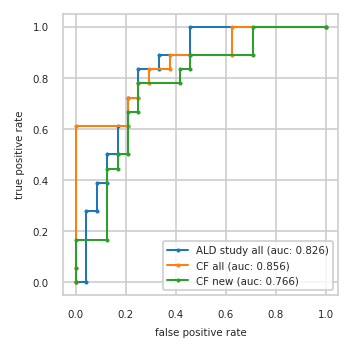

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.278  0.000 0.611  0.000 0.167
3          0.083 0.278  0.208 0.611  0.125 0.167
4          0.083 0.389  0.208 0.722  0.125 0.444
5          0.125 0.389  0.250 0.722  0.167 0.444
6          0.125 0.500  0.250 0.778  0.167 0.500
7          0.167 0.500  0.292 0.778  0.208 0.500
8          0.167 0.611  0.292 0.833  0.208 0.667
9          0.208 0.611  0.375 0.833  0.250 0.667
10         0.208 0.722  0.375 0.889  0.250 0.778
11         0.250 0.722  0.625 0.889  0.417 0.778
12         0.250 0.833  0.625 1.000  0.417 0.833
13         0.333 0.833  1.000 1.000  0.458 0.833
14         0.333 0.889    NaN   NaN  0.458 0.889
15         0.458 0.889    NaN   NaN  0.708 0.889
16         0.458 1.000    NaN   NaN  0.708 1.000
17         1.000 1.000    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,Q9NX62,Q16799
2,P01701,Q86V85,P51688
3,Q02818,P08253,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
4,P61981,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P04075,Q96GD0
6,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P14174,Q9NUQ9
8,Q9Y2T3;Q9Y2T3-3,Q14894,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


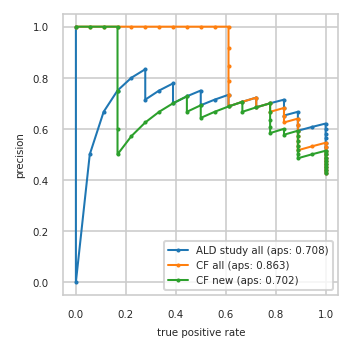

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.516 0.889     0.516 0.889
12         0.600 1.000     0.533 0.889     0.533 0.889
13         0.621 1.000     0.552 0.889     0.552 0.889
14         0.607 0.944     0.571 0.889     0.571 0.889
15         0.593 0.889     0.593 0.889     0.593 0.889
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.714 0.833     0.667 0.778     0.667 0.778
22         0.700 0.778     0.700 0.778     0.700 0.778
23         0.684 0.722     0.684 0.722     0.684 0.722
24         0.722 0.722     0.722 0.722     0.667 0.667
25         0.706 0.667     0.706 0.667     0.706 0.667
26         0.688 0.611     0.688 0.611     0.688 0.611
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.692 0.500     0.846 0.611     0.692 0.500
30         0.750 0.500     0.917 0.611     0.667 0.444
31         0.727 0.444     1.000 0.611     0.727 0.444
32         0.700 0.389     1.000 0.556     0.700 0.389
33         0.778 0.389     1.000 0.500     0.667 0.333
34         0.750 0.333     1.000 0.444     0.625 0.278
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


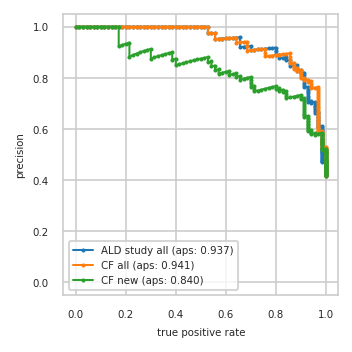

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


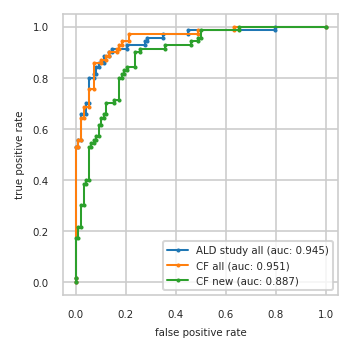

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}